In [1]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

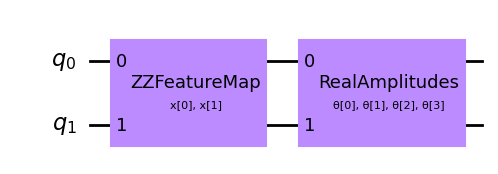

In [2]:
num_inputs = 2

feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)
qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)

qnn = EstimatorQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    input_gradients=True,
)

qc.draw("mpl")

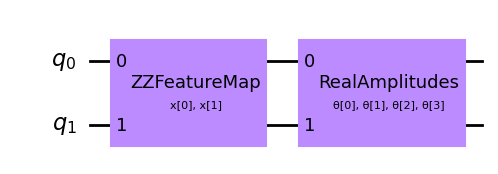

In [3]:
qc.draw("mpl")

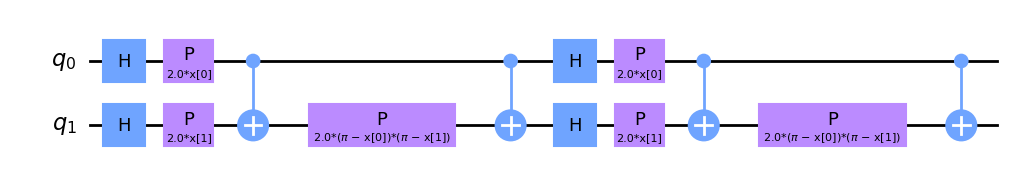

In [4]:
feature_map.decompose().draw("mpl")

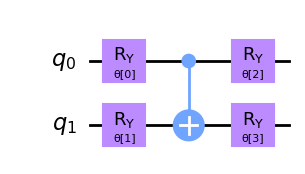

In [5]:
ansatz.decompose().draw("mpl")

In [6]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, cat
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [7]:
batch_size = 1
n_samples = 100

X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
# ラベルが0と1のものだけ取り出す
train_idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[train_idx]
X_train.targets = X_train.targets[train_idx]
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[test_idx]
X_test.targets = X_test.targets[test_idx]
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [8]:
class Net(nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, kernel_size=5)
        self.conv2 = nn.Conv2d(2, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 2)
        self.qnn = TorchConnector(qnn)
            # 入力が2次元、出力が1次元、出力の値の範囲は-1から1まで。
        self.fc3 = nn.Linear(1, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)
        x = self.fc3(x)
        return cat((x, 1 - x), -1)

model = Net(qnn)
print(model)

Net(
  (conv1): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(2, 16, kernel_size=(5, 5), stride=(1, 1))
  (dropout): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (qnn): TorchConnector()
  (fc3): Linear(in_features=1, out_features=1, bias=True)
)


In [9]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Training: loss: {loss:>7f}")

In [10]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test: loss: {test_loss:>8f}, Accuracy: {(100*correct):>0.1f}%\n")

In [11]:
loss_fn = nn.NLLLoss()
#loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)

Epoch 1
-------------------------------
Training: loss: -0.622308
Test: loss: -0.560002, Accuracy: 61.5%

Epoch 2
-------------------------------
Training: loss: -0.930984
Test: loss: -0.685461, Accuracy: 81.0%

Epoch 3
-------------------------------
Training: loss: -1.028172
Test: loss: -0.984896, Accuracy: 96.5%

Epoch 4
-------------------------------
Training: loss: -0.524168
Test: loss: -1.178996, Accuracy: 96.0%

Epoch 5
-------------------------------
Training: loss: -1.391059
Test: loss: -1.381660, Accuracy: 99.0%

